# LVDT Position Simulation
### Here we will simulate the position measurement of a reversed LVDT with geometry as used in ETpathfinder large IP. 

#### Import everything and open FEMM

In [1]:
import femm
import numpy as np
import cmath
import scipy.optimize as opt
import matplotlib.pyplot as plt

# The package must be initialized with the openfemm command.
femm.openfemm()

# We need to create a new Magnetostatics document to work on.
femm.newdocument(0)

#### Set main parameters of simulation

In [2]:
Description_Txt		= "RevLVDT ETpathfinder large IP geometry"
outputfile = 'RevLVDT_Position_ETpf_LIP_10kHz_20mA_32AWG.out'
OutCoil_Distance	= 54.5 # distance between mid points of outer coils. Space between coils is then OutCoil_Distance - OutCoil_Height
InnCoil_Distance	= 0 # offset distance for inner coil
InnCoil_Current		= 0.00 # Normal LVDT: put current on inner coil
OutCoil_Current		= 0.02 # Reversed LVDT: put current on outer coils
SimulationFreq		= 10000.0 # AC frequency
NSteps                  = 10
StepSize                = 1
InnCoil_Offset          = -5

# Define the problem type.  Magnetostatic; Units of mm; Axisymmetric; 
# Precision of 10^(-10) for the linear solver
femm.mi_probdef( SimulationFreq, 'millimeters', 'axi', 1.0e-10)

#### Now we have to construct the geometry of our model
Parameters of the inner coil:

In [3]:
InnCoil_WireType	= "32 AWG"
InnCoil_WireDiam	= 0.2032    # with heavy build, diameter: 0.23876
InnCoil_WireInsul   = 0.0178
InnCoil_NrWireLayers	= 6
InnCoil_InRadius	= 11
InnCoil_Height		= 24

Parameters for outer coils:

In [4]:
UppOutCoil_WireType	    = "32 AWG"
UppOutCoil_WireDiam		= 0.2032
UppOutCoil_WireInsul    = 0.0178
UppOutCoil_NrWireLayers		= 5
UppOutCoil_InRadius		= 35
UppOutCoil_Height		= 13.5

LowOutCoil_WireType		= "32 AWG"
LowOutCoil_WireDiam		= 0.2032
LowOutCoil_WireInsul    = 0.0178
LowOutCoil_NrWireLayers		= 5
LowOutCoil_InRadius		= 35
LowOutCoil_Height		= 13.5

Parameters of voice coil magnet:

In [5]:
Magnet_Length				=	 40
Magnet_Diameter				=	10
Magnet_Material				=	"N40"
Magnet_VertShift			=	 0

Calculate all coil positions:

In [6]:
InnCoil_OutRadius	= InnCoil_InRadius + (InnCoil_WireDiam * InnCoil_NrWireLayers)
InnCoil_LowEnd		= (InnCoil_Distance - InnCoil_Height) / 2
InnCoil_UppEnd		= InnCoil_LowEnd + InnCoil_Height
InnCoil_NrWind_p_Layer	= (InnCoil_Height) / (InnCoil_WireDiam + InnCoil_WireInsul)
InnCoil_NrWindings	= InnCoil_NrWind_p_Layer * InnCoil_NrWireLayers
InnCoil_Circuit		= "InnCoil_Circuit"

print("Inner coil: inner radius = {:.2f}".format(InnCoil_InRadius),
      "outer radius = {:.2f}".format(InnCoil_OutRadius), 
      "#windings/layer = {:.2f}".format(InnCoil_NrWind_p_Layer),
      "total windings = {:.2f}".format(InnCoil_NrWindings))
InnCoil_TotalWire = 0
for i in range(0,InnCoil_NrWireLayers):
    circ = 2*np.pi*InnCoil_InRadius+i*(InnCoil_WireDiam+InnCoil_WireInsul)
    InnCoil_TotalWire += circ*InnCoil_NrWind_p_Layer
print("Total length of wire (mm):", InnCoil_TotalWire)
print("Lower end = {:.2f}".format(InnCoil_LowEnd), "Upper end = {:.2f}".format(InnCoil_UppEnd))

UppOutCoil_OutRadius		= UppOutCoil_InRadius + (UppOutCoil_WireDiam*UppOutCoil_NrWireLayers)
UppOutCoil_LowEnd		= (OutCoil_Distance - UppOutCoil_Height) / 2
UppOutCoil_UppEnd		= UppOutCoil_LowEnd + UppOutCoil_Height
UppOutCoil_NrWind_p_Layer	= (UppOutCoil_Height) / (UppOutCoil_WireDiam + UppOutCoil_WireInsul)
UppOutCoil_NrWindings		= UppOutCoil_NrWind_p_Layer * UppOutCoil_NrWireLayers
UppOutCoil_Circuit	= "UppOutCoil_Circuit"

print("Upper outer coil: inner radius = {:.2f}".format(UppOutCoil_InRadius),
      "outer radius = {:.2f}".format(UppOutCoil_OutRadius),
      "#windings/layer = {:.2f}".format(UppOutCoil_NrWind_p_Layer),
      "total windings = {:.2f}".format(UppOutCoil_NrWindings))
UppOutCoil_TotalWire = 0
for i in range(0,UppOutCoil_NrWireLayers):
    circ = 2*np.pi*UppOutCoil_InRadius+i*(UppOutCoil_WireDiam+UppOutCoil_WireInsul)
    UppOutCoil_TotalWire += circ*UppOutCoil_NrWind_p_Layer
print("Total length of wire (mm):", UppOutCoil_TotalWire)
print("Lower end = {:.2f}".format(UppOutCoil_LowEnd), "Upper end = {:.2f}".format(UppOutCoil_UppEnd))

LowOutCoil_OutRadius		= LowOutCoil_InRadius + (LowOutCoil_WireDiam*LowOutCoil_NrWireLayers)
LowOutCoil_UppEnd		= -1*(OutCoil_Distance - LowOutCoil_Height) / 2
LowOutCoil_LowEnd		= LowOutCoil_UppEnd - LowOutCoil_Height
LowOutCoil_NrWind_p_Layer	= (LowOutCoil_UppEnd-LowOutCoil_LowEnd) / (LowOutCoil_WireDiam + LowOutCoil_WireInsul)
LowOutCoil_NrWindings		= LowOutCoil_NrWind_p_Layer * LowOutCoil_NrWireLayers
LowOutCoil_Circuit	= "LowOutCoil_Circuit"

print("Lower outer coil: inner radius = {:.2f}".format(LowOutCoil_InRadius),
      "outer radius = {:.2f}".format(LowOutCoil_OutRadius),
      "#windings/layer = {:.2f}".format(LowOutCoil_NrWind_p_Layer),
      "total windings = {:.2f}".format(LowOutCoil_NrWindings))
LowOutCoil_TotalWire = 0
for i in range(0,LowOutCoil_NrWireLayers):
    circ = 2*np.pi*LowOutCoil_InRadius+i*(LowOutCoil_WireDiam+LowOutCoil_WireInsul)
    LowOutCoil_TotalWire += circ*LowOutCoil_NrWind_p_Layer
print("Total length of wire (mm):", LowOutCoil_TotalWire)
print("Lower end = {:.2f}".format(LowOutCoil_LowEnd), "Upper end = {:.2f}".format(LowOutCoil_UppEnd))

Magnet_UppEnd				=	 Magnet_Length / 2 + Magnet_VertShift
Magnet_LowEnd				=	-Magnet_Length / 2 + Magnet_VertShift
Magnet_Radius				=	 Magnet_Diameter / 2

print("Voice coil magnet: Magnet Radius = {:.2f}".format(Magnet_Radius),
      "Upper end = {:.2f}".format(Magnet_UppEnd),
      "Lower end = {:.2f}".format(Magnet_LowEnd))


Inner coil: inner radius = 11.00 outer radius = 12.22 #windings/layer = 108.60 total windings = 651.58
Total length of wire (mm): 45394.23315191159
Lower end = -12.00 Upper end = 12.00
Upper outer coil: inner radius = 35.00 outer radius = 36.02 #windings/layer = 61.09 total windings = 305.43
Total length of wire (mm): 67302.53524077724
Lower end = 20.50 Upper end = 34.00
Lower outer coil: inner radius = 35.00 outer radius = 36.02 #windings/layer = 61.09 total windings = 305.43
Total length of wire (mm): 67302.53524077724
Lower end = -34.00 Upper end = -20.50
Voice coil magnet: Magnet Radius = 5.00 Upper end = 20.00 Lower end = -20.00


#### Build geometry of simulation with all properties

In [7]:
'''# Draw a rectangle for the inner coil
femm.mi_drawrectangle(InnCoil_InRadius, InnCoil_LowEnd, InnCoil_OutRadius, InnCoil_UppEnd)
femm.mi_addblocklabel(InnCoil_InRadius + InnCoil_WireDiam/2, InnCoil_Distance)
femm.mi_getmaterial(InnCoil_WireType)

# Add a "circuit property" so that we can calculate the properties of the
# coil as seen from the terminals.
femm.mi_addcircprop(InnCoil_Circuit, InnCoil_Current, 1)

# Apply the materials to the appropriate block labels
femm.mi_selectlabel(InnCoil_InRadius + InnCoil_WireDiam/2, InnCoil_Distance)
femm.mi_setblockprop(InnCoil_WireType, 1, 0, InnCoil_Circuit, 0, 0, InnCoil_NrWindings)
                        #-- BlockName
                        #-- automesh: is 0 in example
                        #-- meshsize: is 1 in example
                        #-- part of Circuit
                        #-- magnetisation-direction
                        #-- GroupNr			
                        #-- #turns
femm.mi_selectrectangle(InnCoil_InRadius, InnCoil_LowEnd, InnCoil_OutRadius, InnCoil_UppEnd, 4)
femm.mi_setgroup(1)
femm.mi_clearselected()'''

femm.mi_addnode(InnCoil_InRadius,		InnCoil_UppEnd)
femm.mi_addnode(InnCoil_InRadius,		InnCoil_LowEnd)
femm.mi_addnode(InnCoil_OutRadius, 		InnCoil_UppEnd)
femm.mi_addnode(InnCoil_OutRadius, 		InnCoil_LowEnd)
femm.mi_addnode(0,						InnCoil_UppEnd)
femm.mi_addnode(InnCoil_InRadius,		0)
femm.mi_addnode(0,						InnCoil_LowEnd)
femm.mi_addsegment(InnCoil_InRadius,		InnCoil_UppEnd,		InnCoil_OutRadius,	InnCoil_UppEnd)
femm.mi_addsegment(InnCoil_OutRadius,	InnCoil_UppEnd,		InnCoil_OutRadius,	InnCoil_LowEnd)
femm.mi_addsegment(InnCoil_OutRadius,	InnCoil_LowEnd,		InnCoil_InRadius,	InnCoil_LowEnd)
femm.mi_addsegment(InnCoil_InRadius,		InnCoil_LowEnd,		InnCoil_InRadius,	InnCoil_UppEnd)
femm.mi_addcircprop(InnCoil_Circuit, InnCoil_Current, 1)
femm.mi_getmaterial(InnCoil_WireType)

femm.mi_clearselected()
femm.mi_selectnode(InnCoil_InRadius,		InnCoil_UppEnd)
femm.mi_selectnode(InnCoil_InRadius,		InnCoil_LowEnd)
femm.mi_selectnode(InnCoil_OutRadius, 	InnCoil_UppEnd)
femm.mi_selectnode(InnCoil_OutRadius,	InnCoil_LowEnd)
femm.mi_selectnode(0,					InnCoil_UppEnd)
femm.mi_selectnode(InnCoil_InRadius,		0)
femm.mi_selectnode(0,					InnCoil_LowEnd)
femm.mi_selectsegment(InnCoil_InRadius,	InnCoil_UppEnd)
femm.mi_selectsegment(InnCoil_OutRadius,	InnCoil_UppEnd)
femm.mi_selectsegment(InnCoil_OutRadius,	InnCoil_LowEnd)
femm.mi_selectsegment(InnCoil_InRadius,	InnCoil_LowEnd)

femm.mi_setgroup(1)
femm.mi_clearselected()
femm.mi_addblocklabel(InnCoil_InRadius + (InnCoil_WireDiam/2),InnCoil_LowEnd + InnCoil_Height/2)
femm.mi_selectlabel(  InnCoil_InRadius + (InnCoil_WireDiam/2),InnCoil_LowEnd + InnCoil_Height/2)
femm.mi_setblockprop(InnCoil_WireType, 1, 0, InnCoil_Circuit, 0, 1 ,InnCoil_NrWindings)
femm.mi_clearselected()







'''# Draw a rectangle for the upper outer coil
femm.mi_drawrectangle(UppOutCoil_InRadius, UppOutCoil_LowEnd, UppOutCoil_OutRadius, UppOutCoil_UppEnd)
femm.mi_addblocklabel(UppOutCoil_InRadius + UppOutCoil_WireDiam/2, UppOutCoil_LowEnd + UppOutCoil_Height/2)
femm.mi_getmaterial(UppOutCoil_WireType)

# Add a "circuit property" so that we can calculate the properties of the
# coil as seen from the terminals.
femm.mi_addcircprop(UppOutCoil_Circuit, OutCoil_Current, 1)

# Apply the materials to the appropriate block labels
femm.mi_selectlabel(UppOutCoil_InRadius + UppOutCoil_WireDiam/2, UppOutCoil_LowEnd + UppOutCoil_Height/2)
femm.mi_setblockprop(UppOutCoil_WireType, 0, 0.1, UppOutCoil_Circuit, 0, 0, UppOutCoil_NrWindings)
femm.mi_clearselected()'''

femm.mi_addnode(UppOutCoil_InRadius,		UppOutCoil_UppEnd)
femm.mi_addnode(UppOutCoil_InRadius,		UppOutCoil_LowEnd)
femm.mi_addnode(UppOutCoil_OutRadius,	UppOutCoil_UppEnd)
femm.mi_addnode(UppOutCoil_OutRadius,	UppOutCoil_LowEnd)
femm.mi_addnode( 0,   UppOutCoil_UppEnd)
femm.mi_addnode( 0,   UppOutCoil_LowEnd)
femm.mi_addsegment(UppOutCoil_InRadius,	UppOutCoil_UppEnd,	UppOutCoil_OutRadius, 	UppOutCoil_UppEnd)
femm.mi_addsegment(UppOutCoil_OutRadius, UppOutCoil_UppEnd,  UppOutCoil_OutRadius,	UppOutCoil_LowEnd)
femm.mi_addsegment(UppOutCoil_OutRadius, UppOutCoil_LowEnd,	UppOutCoil_InRadius,	UppOutCoil_LowEnd)
femm.mi_addsegment(UppOutCoil_InRadius,	UppOutCoil_LowEnd,	UppOutCoil_InRadius,	UppOutCoil_UppEnd)
femm.mi_addcircprop(UppOutCoil_Circuit, OutCoil_Current, 1)

femm.mi_clearselected()
femm.mi_selectnode(UppOutCoil_InRadius,		UppOutCoil_UppEnd)
femm.mi_selectnode(UppOutCoil_InRadius,		UppOutCoil_LowEnd)
femm.mi_selectnode(UppOutCoil_OutRadius, 	UppOutCoil_UppEnd)
femm.mi_selectnode(UppOutCoil_OutRadius,		UppOutCoil_LowEnd)
femm.mi_selectnode( 0,  						UppOutCoil_UppEnd)
femm.mi_selectnode( 0,						UppOutCoil_LowEnd)
femm.mi_selectsegment(UppOutCoil_InRadius,	UppOutCoil_UppEnd)
femm.mi_selectsegment(UppOutCoil_OutRadius,	UppOutCoil_UppEnd)
femm.mi_selectsegment(UppOutCoil_OutRadius,	UppOutCoil_LowEnd)
femm.mi_selectsegment(UppOutCoil_InRadius,	UppOutCoil_LowEnd)

femm.mi_setgroup(3)
femm.mi_clearselected()
femm.mi_getmaterial(  UppOutCoil_WireType)
femm.mi_addblocklabel(UppOutCoil_InRadius + (UppOutCoil_WireDiam/2), UppOutCoil_UppEnd*0.95)
femm.mi_selectlabel(  UppOutCoil_InRadius + (UppOutCoil_WireDiam/2), UppOutCoil_UppEnd*0.95)
femm.mi_setblockprop( UppOutCoil_WireType, 0, 0.1, UppOutCoil_Circuit, 0.0, 3, UppOutCoil_NrWindings)
femm.mi_clearselected()








'''# Draw a rectangle for the Lower outer coil
femm.mi_drawrectangle(LowOutCoil_InRadius, LowOutCoil_LowEnd, LowOutCoil_OutRadius, LowOutCoil_UppEnd)
femm.mi_addblocklabel(LowOutCoil_InRadius + LowOutCoil_WireDiam/2, LowOutCoil_LowEnd + LowOutCoil_Height/2)
femm.mi_getmaterial(LowOutCoil_WireType)

# Add a "circuit property" so that we can calculate the properties of the
# coil as seen from the terminals.
femm.mi_addcircprop(LowOutCoil_Circuit, -1*OutCoil_Current, 1)

# Apply the materials to the appropriate block labels
femm.mi_selectlabel(LowOutCoil_InRadius + LowOutCoil_WireDiam/2, LowOutCoil_LowEnd + LowOutCoil_Height/2)
femm.mi_setblockprop(LowOutCoil_WireType, 0, 0.1, LowOutCoil_Circuit, 0, 0, LowOutCoil_NrWindings)
femm.mi_clearselected()'''

femm.mi_addnode(LowOutCoil_InRadius,		LowOutCoil_UppEnd)
femm.mi_addnode(LowOutCoil_InRadius,		LowOutCoil_LowEnd)
femm.mi_addnode(LowOutCoil_OutRadius,	LowOutCoil_UppEnd)
femm.mi_addnode(LowOutCoil_OutRadius,	LowOutCoil_LowEnd)
femm.mi_addnode( 0,   LowOutCoil_UppEnd)
femm.mi_addnode( 0,   LowOutCoil_LowEnd)
femm.mi_addsegment(LowOutCoil_InRadius,	LowOutCoil_UppEnd, LowOutCoil_OutRadius,	LowOutCoil_UppEnd)
femm.mi_addsegment(LowOutCoil_OutRadius, LowOutCoil_UppEnd, LowOutCoil_OutRadius,	LowOutCoil_LowEnd)
femm.mi_addsegment(LowOutCoil_OutRadius, LowOutCoil_LowEnd, LowOutCoil_InRadius,		LowOutCoil_LowEnd)
femm.mi_addsegment(LowOutCoil_InRadius,	LowOutCoil_LowEnd, LowOutCoil_InRadius,		LowOutCoil_UppEnd)
femm.mi_addcircprop(LowOutCoil_Circuit, -OutCoil_Current, 1)

femm.mi_clearselected()
femm.mi_selectnode(LowOutCoil_InRadius,		LowOutCoil_UppEnd)
femm.mi_selectnode(LowOutCoil_InRadius,		LowOutCoil_LowEnd)
femm.mi_selectnode(LowOutCoil_OutRadius, 	LowOutCoil_UppEnd)
femm.mi_selectnode(LowOutCoil_OutRadius,		LowOutCoil_LowEnd)
femm.mi_selectnode( 0,   					LowOutCoil_UppEnd)
femm.mi_selectnode( 0,   					LowOutCoil_LowEnd)
femm.mi_selectsegment(LowOutCoil_InRadius,	LowOutCoil_UppEnd)
femm.mi_selectsegment(LowOutCoil_OutRadius,	LowOutCoil_UppEnd)
femm.mi_selectsegment(LowOutCoil_OutRadius,	LowOutCoil_LowEnd)
femm.mi_selectsegment(LowOutCoil_InRadius,	LowOutCoil_LowEnd)
femm.mi_setgroup(4)
femm.mi_clearselected()

femm.mi_getmaterial(LowOutCoil_WireType)
femm.mi_addblocklabel(LowOutCoil_InRadius + (LowOutCoil_WireDiam/2), LowOutCoil_LowEnd*0.95)
femm.mi_selectlabel(  LowOutCoil_InRadius + (LowOutCoil_WireDiam/2), LowOutCoil_LowEnd*0.95)
femm.mi_setblockprop(LowOutCoil_WireType, 0, 0.1, LowOutCoil_Circuit, 0.0, 4, LowOutCoil_NrWindings)
femm.mi_clearselected()









'''# Draw a rectangle for the voice coil magnet
femm.mi_drawrectangle(0, Magnet_LowEnd, Magnet_Radius, Magnet_UppEnd)
femm.mi_addblocklabel(Magnet_Radius/2, 0)
femm.mi_getmaterial(Magnet_Material)

# Apply the materials to the appropriate block labels
femm.mi_selectlabel(Magnet_Radius/2, 0)
femm.mi_setblockprop(Magnet_Material, 0, 0.1, "", 90, 0, 0)
                        #-- BlockName
                        #-- automesh: is 0 in example
                        #-- meshsize: is 1 in example
                        #-- part of Circuit
                        #-- magnetisation-direction
                        #-- GroupNr			
                        #-- #turns
femm.mi_selectrectangle(0, Magnet_LowEnd, Magnet_Radius, Magnet_UppEnd, 4)
femm.mi_setgroup(2)
femm.mi_clearselected()'''

femm.mi_addnode(0,				Magnet_UppEnd)
femm.mi_addnode(Magnet_Radius,	Magnet_UppEnd)
femm.mi_addnode(0,				Magnet_LowEnd)
femm.mi_addnode(Magnet_Radius,	Magnet_LowEnd)
femm.mi_addsegment(0,				Magnet_UppEnd,		Magnet_Radius,	Magnet_UppEnd)
femm.mi_addsegment(Magnet_Radius,	Magnet_UppEnd,		Magnet_Radius,	Magnet_LowEnd)
femm.mi_addsegment(Magnet_Radius,	Magnet_LowEnd,		0,				Magnet_LowEnd)
femm.mi_addsegment(0,				Magnet_LowEnd,		0,				Magnet_UppEnd)
femm.mi_clearselected()

femm.mi_selectnode(0,				Magnet_UppEnd)
femm.mi_selectnode(Magnet_Radius,	Magnet_UppEnd)
femm.mi_selectnode(0,				Magnet_LowEnd)
femm.mi_selectnode(Magnet_Radius,	Magnet_LowEnd)
femm.mi_selectsegment(0,				Magnet_UppEnd)
femm.mi_selectsegment(Magnet_Radius,	Magnet_UppEnd)
femm.mi_selectsegment(Magnet_Radius,	Magnet_LowEnd)
femm.mi_selectsegment(0,				Magnet_LowEnd)
femm.mi_setgroup(2)
femm.mi_clearselected()

femm.mi_getmaterial(Magnet_Material)
femm.mi_addblocklabel(.5, Magnet_UppEnd-1)
femm.mi_selectlabel(  .5, Magnet_UppEnd-1)
femm.mi_setblockprop(Magnet_Material, 0, 0.1, "", 90, 2, 0)
femm.mi_clearselected()










'''# Add Air surroundings
femm.mi_addblocklabel(30,50)
femm.mi_addmaterial('Air', 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)

femm.mi_selectlabel(30,50)
femm.mi_setblockprop('Air', 0, 0.5, '<None>', 0, 0, 0)
femm.mi_clearselected()

# Define an "open" boundary condition using the built-in function:
femm.mi_makeABC()'''


# Fred's way
AirSpaceRadius_1 = 100
AirSpaceRadius_2 = 300
BC_Name = "Outside"
BC_Group = 10

'''femm.mi_drawarc(0, -1*AirSpaceRadius_1 ,0, AirSpaceRadius_1, 180, 2)
femm.mi_addsegment(0, -1*AirSpaceRadius_1, 0, AirSpaceRadius_1)
femm.mi_getmaterial("Air")
femm.mi_addblocklabel(AirSpaceRadius_1/4, AirSpaceRadius_1/2)
femm.mi_selectlabel(  AirSpaceRadius_1/4, AirSpaceRadius_1/2)
femm.mi_setblockprop("Air", 0, 0.5, '', 0.0, 0, 0)
femm.mi_clearselected()

femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

femm.mi_drawarc(0, -1*AirSpaceRadius_2, 0, AirSpaceRadius_2, 180, 2)
femm.mi_addsegment(0, -1*AirSpaceRadius_2, 0, AirSpaceRadius_2)
femm.mi_selectarcsegment( 0, AirSpaceRadius_2)
femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)
femm.mi_clearselected()
femm.mi_getmaterial("Air")
femm.mi_addblocklabel(AirSpaceRadius_2/2, AirSpaceRadius_2/1.2)
femm.mi_selectlabel(  AirSpaceRadius_2/2, AirSpaceRadius_2/1.2)
femm.mi_setblockprop("Air", 1, 0, '', 0.0, 0, 0)
femm.mi_clearselected()'''




femm.mi_addnode(0,     				 0)
femm.mi_addnode(0,   				 AirSpaceRadius_1)
femm.mi_addnode(AirSpaceRadius_1,   	 0)
femm.mi_addnode(0,  					-AirSpaceRadius_1)

femm.mi_addsegment(0,				 AirSpaceRadius_1,	0,   				 0)
femm.mi_addsegment(0,  				 0,					0,					-AirSpaceRadius_1)

femm.mi_addarc(AirSpaceRadius_1,   	0,  				0,		 			 AirSpaceRadius_1,	90,		2)
femm.mi_addarc(0,					-AirSpaceRadius_1,	AirSpaceRadius_1,	0,					90,		2)

femm.mi_getmaterial("Air")
femm.mi_addblocklabel(AirSpaceRadius_1/4,	AirSpaceRadius_1/2)
femm.mi_selectlabel(  AirSpaceRadius_1/4,	AirSpaceRadius_1/2)
femm.mi_setblockprop("Air",0,0.5,'',0.0,0,0)
femm.mi_clearselected()

femm.mi_addboundprop(BC_Name, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

femm.mi_addnode(0,     				 0)
femm.mi_addnode(0,   				 AirSpaceRadius_2)
femm.mi_addnode(AirSpaceRadius_2,   	 0)
femm.mi_addnode(0,  					-AirSpaceRadius_2)

femm.mi_addsegment(0,				 AirSpaceRadius_2,	 0,   				 0)
femm.mi_addsegment(0,				 0,					 0,					-AirSpaceRadius_2)

femm.mi_addarc(AirSpaceRadius_2,   	 0,  				 0,					 AirSpaceRadius_2, 90, 2)
femm.mi_selectarcsegment(			 0,					 AirSpaceRadius_2)
femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)
femm.mi_clearselected()

femm.mi_addarc(0,					-AirSpaceRadius_2,	 AirSpaceRadius_2,	 0,		 		   90, 2)
femm.mi_selectarcsegment(			 0,					-AirSpaceRadius_2) 
femm.mi_setarcsegmentprop(2, BC_Name, 0, BC_Group)
femm.mi_clearselected()

femm.mi_getmaterial("Air")
femm.mi_addblocklabel(AirSpaceRadius_2/2,	AirSpaceRadius_2/1.2)
femm.mi_selectlabel(  AirSpaceRadius_2/2,	AirSpaceRadius_2/1.2)
femm.mi_setblockprop("Air",	1,	0,	'',	0.0,	0,	0)

femm.mi_clearselected()

#### Geometry is finished now, start simulation and loop to change inner coil distances

Define output variables used to store data for plotting:

In [8]:
UppOutCoil_Voltages = np.zeros(NSteps+1).astype(complex)
LowOutCoil_Voltages = np.zeros(NSteps+1).astype(complex)
InnCoil_Voltages = np.zeros(NSteps+1).astype(complex)
InnCoil_Positions = np.zeros(NSteps+1)
MetaData = np.zeros(NSteps+1)

Move inner coil and magnet to initial offset position:

In [9]:
femm.mi_selectgroup(1)
femm.mi_selectgroup(2)
femm.mi_movetranslate(0, InnCoil_Offset)
femm.mi_clearselected()

Simulation loop over different positions:

In [10]:
for i in range(0,NSteps+1):

    print(InnCoil_Offset + StepSize*i)
    InnCoil_Positions[i] = InnCoil_Offset + StepSize*i

    # Now, the finished input geometry can be displayed.
    #femm.mi_zoomnatural()
    femm.mi_zoom(-2,-50,50,50)
    femm.mi_refreshview()

    # We have to give the geometry a name before we can analyze it.
    femm.mi_saveas('RevLVDT_Position_ETpf_LIP.fem')

    # Now,analyze the problem and load the solution when the analysis is finished
    femm.mi_analyze()
    femm.mi_loadsolution()

    if NSteps == 0:
        # Show Density Plot:
        femm.mo_showdensityplot(1, 0, 0.0001, 1.0E-9, "bmag")
                #--legend,	(0=hide, 1=show)
                #--gscale,	(0=color, 1=greyscale)
                #--upper_B,	(upperlimit for display)
                #--lower_B,	(lowerlimit for display)
                #--type		("bmag", "breal", "bimag" FluxDensity)
                #--			("hmag", "hreal", "himag" FieldIntensity)
                #--			("jmag", "jreal", "jimag" CurrentDensity)
        femm.mo_zoom(-2,-50,50,50)
        femm.mo_refreshview()

    UppOutCoil_I, UppOutCoil_V, UppOutCoil_FluxLink = femm.mo_getcircuitproperties(UppOutCoil_Circuit)
    print("Upper OuterCoil: I= {:.3f}, V = {:.6f} ".format(UppOutCoil_I, UppOutCoil_V))
    UppOutCoil_Voltages[i] = UppOutCoil_V

    LowOutCoil_I, LowOutCoil_V, LowOutCoil_FluxLink = femm.mo_getcircuitproperties(LowOutCoil_Circuit)
    print("Lower OuterCoil: I= {:.3f}, V = {:.6f} ".format(LowOutCoil_I, LowOutCoil_V))
    LowOutCoil_Voltages[i] = LowOutCoil_V

    InnCoil_I, InnCoil_V, InnCoil_FluxLink = femm.mo_getcircuitproperties(InnCoil_Circuit)
    print("InnerCoil: I= {:.3f}, V = {:.8f} ".format(InnCoil_I, InnCoil_V))
    InnCoil_Voltages[i] = InnCoil_V

    # Translate inner coil to different distance
    femm.mi_selectgroup(1)
    femm.mi_selectgroup(2)
    femm.mi_movetranslate(0, StepSize)
    femm.mi_clearselected()

-5
Upper OuterCoil: I= 0.020, V = 0.726534+11.937325j 
Lower OuterCoil: I= -0.020, V = -0.729815-11.937669j 
InnerCoil: I= 0.000, V = -0.00939805-0.37417247j 
-4
Upper OuterCoil: I= 0.020, V = 0.726794+11.937342j 
Lower OuterCoil: I= -0.020, V = -0.729434-11.937670j 
InnerCoil: I= 0.000, V = -0.00754543-0.30013377j 
-3
Upper OuterCoil: I= 0.020, V = 0.727072+11.937390j 
Lower OuterCoil: I= -0.020, V = -0.729060-11.937611j 
InnerCoil: I= 0.000, V = -0.00567483-0.22556246j 
-2
Upper OuterCoil: I= 0.020, V = 0.727367+11.937418j 
Lower OuterCoil: I= -0.020, V = -0.728696-11.937566j 
InnerCoil: I= 0.000, V = -0.00379074-0.15058309j 
-1
Upper OuterCoil: I= 0.020, V = 0.727678+11.937421j 
Lower OuterCoil: I= -0.020, V = -0.728343-11.937563j 
InnerCoil: I= 0.000, V = -0.00189751-0.07535562j 
0
Upper OuterCoil: I= 0.020, V = 0.728003+11.937455j 
Lower OuterCoil: I= -0.020, V = -0.728003-11.937489j 
InnerCoil: I= 0.000, V = 0.00000008+0.00000174j 
1
Upper OuterCoil: I= 0.020, V = 0.728343+11.937

Some initial print outs:

In [11]:
print(InnCoil_Positions)
print(UppOutCoil_Voltages)
print(LowOutCoil_Voltages)
print(InnCoil_Voltages)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
[0.72653353+11.93732461j 0.72679439+11.93734157j 0.72707234+11.93738963j
 0.72736703+11.93741776j 0.72767769+11.93742064j 0.72800344+11.93745537j
 0.72834325+11.93747953j 0.7286959 +11.9375195j  0.72905988+11.93753045j
 0.72943367+11.93755096j 0.72981551+11.93759332j]
[-0.72981541-11.93766915j -0.72943361-11.93767043j
 -0.72905988-11.93761132j -0.72869589-11.93756576j
 -0.72834324-11.93756314j -0.72800329-11.93748941j
 -0.72767761-11.93753672j -0.72736693-11.93748657j
 -0.72707226-11.93746606j -0.7267943 -11.93744387j
 -0.7265334 -11.93740346j]
[-9.39804568e-03-3.74172471e-01j -7.54543005e-03-3.00133771e-01j
 -5.67482609e-03-2.25562463e-01j -3.79074059e-03-1.50583085e-01j
 -1.89750936e-03-7.53556232e-02j  8.35748670e-08+1.74243770e-06j
  1.89789897e-03+7.53534188e-02j  3.79134934e-03+1.50586043e-01j
  5.67512794e-03+2.25556064e-01j  7.54642071e-03+3.00134230e-01j
  9.39859085e-03+3.74157565e-01j]


Save numpy arrays to output file

In [12]:
if NSteps > 2:
    MetaData[0] = NSteps
    MetaData[1] = StepSize
    MetaData[2] = OutCoil_Current
    np.savetxt(outputfile, (InnCoil_Positions, UppOutCoil_Voltages, LowOutCoil_Voltages, InnCoil_Voltages, MetaData))

#### Analyse and plot output data
Basic plots:

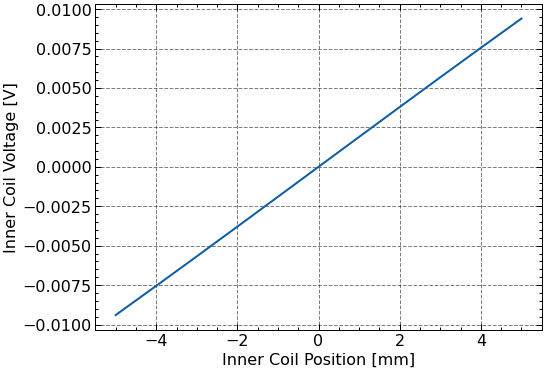

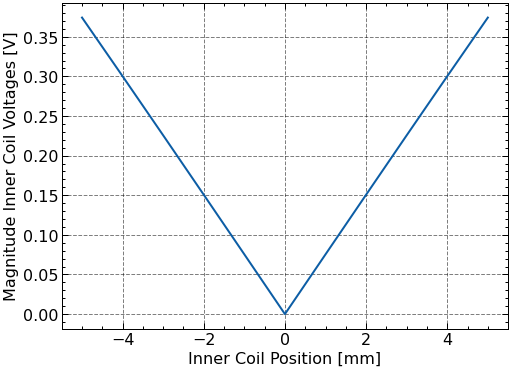

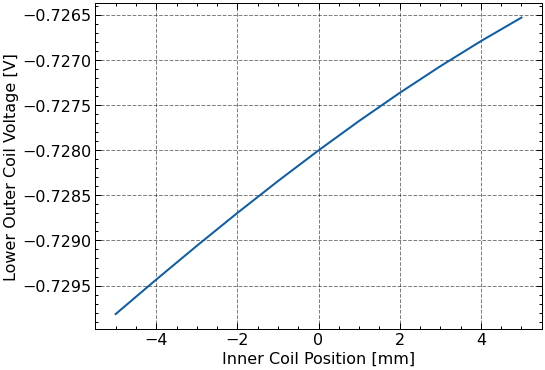

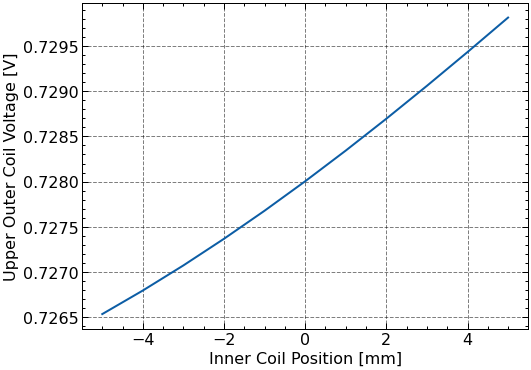

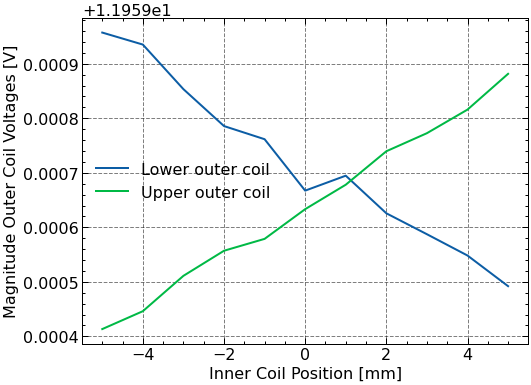

[-1.59590793 -1.59593126 -1.59594958 -1.59596476 -1.59597173  1.52286872
  1.54561502  1.54562435  1.54564103  1.54565814  1.54568227]
[-1.63185583 -1.63182396 -1.63179308 -1.63176293 -1.63173351 -1.63170552
 -1.63167809 -1.63165242 -1.63162793 -1.63160484 -1.63158327]
[1.51000897 1.50998728 1.50996433 1.50993988 1.50991396 1.50988695
 1.50985872 1.50982949 1.50979917 1.50976807 1.50973642]
Phase offset: 0.03594790589228247 0.0359458451179564


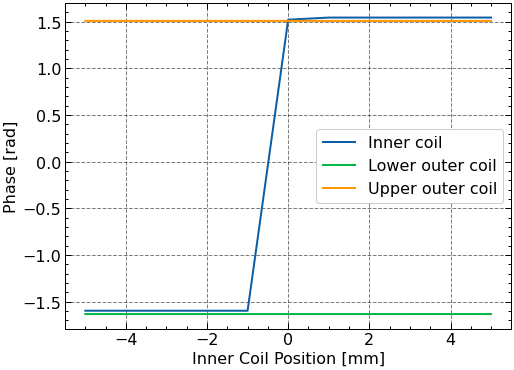

In [13]:
plt.style.use(['science','grid','notebook'])

plt.plot(InnCoil_Positions, InnCoil_Voltages.real)
plt.ylabel('Inner Coil Voltage [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, abs(InnCoil_Voltages))
plt.ylabel('Magnitude Inner Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, LowOutCoil_Voltages.real)
plt.ylabel('Lower Outer Coil Voltage [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, UppOutCoil_Voltages.real)
plt.ylabel('Upper Outer Coil Voltage [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

plt.plot(InnCoil_Positions, abs(LowOutCoil_Voltages), label="Lower outer coil")
plt.plot(InnCoil_Positions, abs(UppOutCoil_Voltages), label="Upper outer coil")
plt.ylabel('Magnitude Outer Coil Voltages [V]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend(frameon=False)
plt.show()


InnCoil_Phases = np.angle(InnCoil_Voltages)
LowOutCoil_Phases = np.angle(LowOutCoil_Voltages)
UppOutCoil_Phases = np.angle(UppOutCoil_Voltages)
print(InnCoil_Phases)
print(LowOutCoil_Phases)
print(UppOutCoil_Phases)
print("Phase offset:", InnCoil_Phases[0] - LowOutCoil_Phases[0], InnCoil_Phases[NSteps] - UppOutCoil_Phases[NSteps])

plt.plot(InnCoil_Positions, InnCoil_Phases, label="Inner coil")
plt.plot(InnCoil_Positions, LowOutCoil_Phases, label="Lower outer coil")
plt.plot(InnCoil_Positions, UppOutCoil_Phases, label="Upper outer coil")
plt.ylabel('Phase [rad]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
plt.show()

Create normalised response of inner coil in V/mmA with magnitude of complex numbers.
flip sign based on phase of signal and fit to check linearity.

Fitted slope of the function: 3.750786763239209


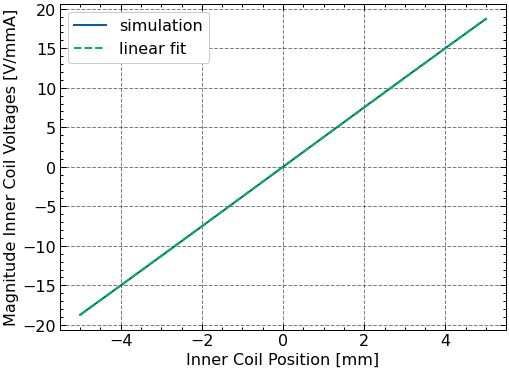

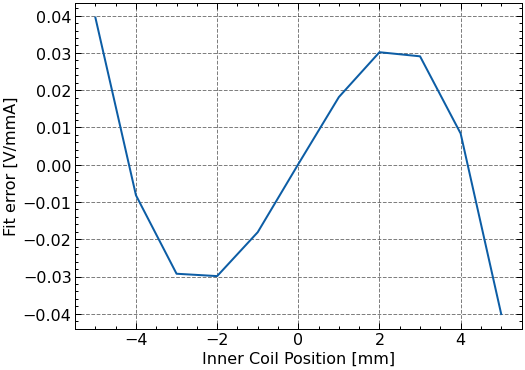

[-1.87540169e+01 -1.50032301e+01 -1.12524433e+01 -7.50165658e+00
 -3.75086982e+00 -8.30561816e-05  3.75070371e+00  7.50149047e+00
  1.12522772e+01  1.50030640e+01  1.87538508e+01]
[-1.87145239e+01 -1.50114302e+01 -1.12816918e+01 -7.53153956e+00
 -3.76897549e+00  8.72220428e-05  3.76886579e+00  7.53168815e+00
  1.12813724e+01  1.50114543e+01  1.87137795e+01]


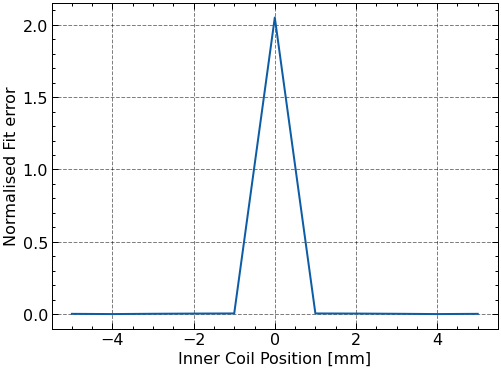

In [14]:
Norm_InnCoil_Signals = abs(InnCoil_Voltages)/StepSize/OutCoil_Current 
for i in range(0,NSteps+1):
    if InnCoil_Phases[i] < 0.0: Norm_InnCoil_Signals[i] *= -1

def linfunc(x, a, b):
     return a*x + b

optimizedParameters, pcov = opt.curve_fit(linfunc, InnCoil_Positions, Norm_InnCoil_Signals);
print("Fitted slope of the function:",optimizedParameters[0])
fitted_Norm_InnCoil_Signals = linfunc(InnCoil_Positions, *optimizedParameters)

plt.plot(InnCoil_Positions, Norm_InnCoil_Signals, label="simulation")
plt.plot(InnCoil_Positions, fitted_Norm_InnCoil_Signals, '--', label="linear fit")
plt.ylabel('Magnitude Inner Coil Voltages [V/mmA]')
plt.xlabel('Inner Coil Position [mm]')
plt.legend()
plt.show()

plt.plot(InnCoil_Positions, Norm_InnCoil_Signals - fitted_Norm_InnCoil_Signals)
plt.ylabel('Fit error [V/mmA]')
plt.xlabel('Inner Coil Position [mm]')
plt.show()

print(fitted_Norm_InnCoil_Signals)
print(Norm_InnCoil_Signals)

plt.plot(InnCoil_Positions, abs(fitted_Norm_InnCoil_Signals - Norm_InnCoil_Signals)/abs(fitted_Norm_InnCoil_Signals))
plt.ylabel('Normalised Fit error')
plt.xlabel('Inner Coil Position [mm]')
#plt.ylim(0.0,0.01)
plt.show()

#### Close FEMM
When the analysis is completed, FEMM can be shut down. Comment out when you want the FEMM window to remain open after simulation to do visual checks.

In [15]:
femm.closefemm()